In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from pykoa.koa import Koa
from tqdm.auto import tqdm

In [2]:
hires_obs = Table.read('koa_out/all.csv')
#sample = Table.read('ollie_stars_w_hires.csv')

In [3]:
#sample = np.genfromtxt('Gr8stars_GaiaeDR3_TIC.tsv', delimiter='\t', names=True, dtype=None, encoding=None)

In [4]:
sample = Table.read('Gr8stars_GaiaeDR3_TIC_hires.csv')

In [5]:
hires_obs = Table.read('koa_out/all.csv')

In [6]:
print('{0} stars queried:'.format(len(sample)))
print('no HIRES spectra at all: {0}'.format(np.sum(sample['n_hires_obs_all'] == 0)))
print('no suitable HIRES spectra: {0}'.format(np.sum(sample['n_hires_obs_iodout'] == 0)))
print('suitable HIRES spectra exist: {0}'.format(np.sum(sample['n_hires_obs_iodout'] > 0)))

2858 stars queried:
no HIRES spectra at all: 1040
no suitable HIRES spectra: 1597
suitable HIRES spectra exist: 1261


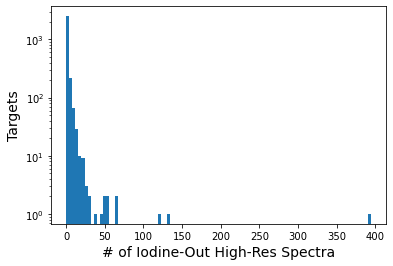

In [7]:
plt.hist(sample['n_hires_obs_iodout'], bins=100)
plt.yscale('log')
plt.xlabel('# of Iodine-Out High-Res Spectra', fontsize=14)
plt.ylabel('Targets', fontsize=14);

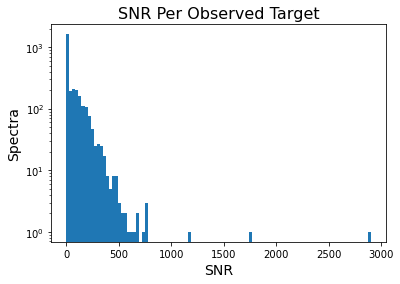

In [8]:
plt.hist(sample['hires_snr'][sample['hires_snr'] >= 0], bins=100)
plt.yscale('log')
plt.title('SNR Per Observed Target', fontsize=16)
plt.xlabel('SNR', fontsize=14)
plt.ylabel('Spectra', fontsize=14);

In [9]:
sample[sample['hires_snr'] >= 1000]

_RAJ2000,_DEJ2000,EDR3Name,RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Source,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Nper,RUWE,FG,e_FG,Gmag,e_Gmag,FBP,e_FBP,BPmag,e_BPmag,FRP,e_FRP,RPmag,e_RPmag,EBPRP,BPRP,RVDR2,e_RVDR2,Tefftemp,loggtemp,FeHtemp,PS1,SDSSDR13,SkyMapper2,URAT1,GmagCorr,e_GmagCorr,FGCorr,EBPRPCorr,RAJ2000,e_RAJ2000,DEJ2000,e_DEJ2000,_RAJ2000_1,_DEJ2000_1,TIC,RAJ2000_1,DEJ2000_1,HIP,TYC,UCAC4,2MASS,objID,WISEA,GAIA,APASS,KIC,SG,Ref,r_Pos,pmRA_1,e_pmRA_1,pmDE_1,e_pmDE_1,r_pm,Plx_1,e_Plx_1,r_Plx,GLON,GLAT,ELON,ELAT,Bmag,e_Bmag,u_e_Bmag,Vmag,e_Vmag,u_e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,q_2MASS,W1mag,e_W1mag,W2mag,e_W2mag,W3mag,e_W3mag,W4mag,e_W4mag,Gmag_1,e_Gmag_1,Tmag,e_Tmag,f_Tmag,Flag,Teff,s_Teff,logg,s_logg,MH,e_MH,Rad,s_Rad,Mass,s_Mass,rho,s_rho,LClass,Lum,s_Lum,Dist,s_Dist,EBV,s_EBV,Ncont,Rcont,Disp,m_TIC,Prior,e_EBV,E_EBV,f_EBV,e_Mass,E_Mass,e_Rad,E_Rad,e_rho,E_rho,e_logg,E_logg,e_Lum,E_Lum,e_Dist,E_Dist,r_Dist,e_Teff,E_Teff,r_Teff,BPmag_1,e_BPmag_1,RPmag_1,e_RPmag_1,q_Gaia,r_Vmag,r_Bmag,Clist,e_RAJ2000_1,e_DEJ2000_1,RAOdeg,DEOdeg,e_RAOdeg,e_DEOdeg,RadFl,WDFl,ID,Sloan,n_hires_obs_all,n_hires_obs_iodout,hires_snr
float64,float64,str29,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,str12,str10,str16,int64,str19,int64,int64,int64,str4,str7,str7,float64,float64,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str5,str5,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str6,float64,float64,float64,float64,int64,str8,str8,str13,float64,float64,float64,float64,float64,float64,int64,int64,int64,str5,int64,int64,int64
133.1492129350178,28.3308208317972,Gaia EDR3 704967037090946688,133.14676062083,0.0299,28.32978300036,0.0198,704967037090946688,79.4482,0.0429,-485.681,0.04,-233.517,0.037,14,0.858,95912000.0,32981.0,5.732681,0.002781,47113000.0,24575.0,6.155681,0.002847,69240000.0,62788.0,5.147009,0.003906,1.213,1.008672,27.26,0.14,5250.0,4.5,0.25,-1,-1,-1,592170930,5.732681,0.002781,95912000.0,-0.005,133.14921302192,0.6424,28.33082086857,0.588,133.149213869445,28.3308213614678,332064670,133.14921386944,28.33082136147,43587,1949-02012-1,592-044667,08523579+2819509,-1,--,704967037090946688,-1,-1,STAR,tmgaia2,tmgaia2,-485.872,0.134,-233.651,0.109,gaia2,79.4274,0.0777,gaia2,196.79465270782,37.69889835833,127.73245213663,10.36709875842,6.816,0.019,0,5.951,0.023,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.768,0.244,4.265,0.234,4.015,0.036,DDE-331-111-000-0-0,nan,nan,nan,nan,nan,nan,nan,nan,5.72973,0.000852,5.206,0.006,gbprp,spect,5250.0,147.6,4.4246,0.0936,0.35,0.1,0.964,0.065,0.9,0.115,1.0062,0.2679,DWARF,0.6354,0.01679,12.5855,0.0123,nan,nan,55,0.0047,--,False,0.008309,nan,nan,--,0.09,0.14,0.053,0.078,0.1542,0.3815,0.1356,0.0515,0.01502,0.01855,0.0123,0.0124,bj2018,171.8,123.3,spect,6.17142,0.000856,5.15789,0.000719,1,sirful,tycho2b3,--,2.14124085412,1.69295593444,133.14683725487,28.32981538469,0.07731272194,0.05221571885,1,0,136527873,Sloan,1268,394,2901
330.794886443164,18.8843192763469,Gaia EDR3 1779546757669063552,330.79502626424,0.0213,18.8842393829,0.0227,1779546757669063552,20

### resolution cuts:

*notes:* 
- sample[9] has 29 observations with R = 717000 and 2 with R = 71600. slit width is the same for all, but binning is different. the following code will throw out the 71600 observations, unclear if that's the desired behavior! 
- how to treat binning differences??
- should there be cuts on filter used or wavelength range? I think no because if the same slit is used with different filters they can still be co-added, just at the expense of "patchy" SNR in the final spectrum-- but should probably ask a HIRES power user about this

In [10]:
from hires_query import filter, coadd_snr

sample['hires_maxres'] = 0.
sample['n_hires_obs_maxres_iodout'] = 0
sample['hires_maxres_snr'] = 0.

for i,s in enumerate(sample):
    obs = hires_obs[hires_obs['EDR3Name'] == s['EDR3Name']]
    obs = obs[obs['specres'] >= 60000]  # minimum resolution cut as in query script
    if len(obs) > 0:
        good = filter(obs)
        if len(good) >= 1:
            max_res = np.max(good['specres'])
            sample[i]['hires_maxres'] = max_res
            good = good[good['specres'] == max_res]
            sample[i]['n_hires_obs_maxres_iodout'] = len(good['koaid'])
            sample[i]['hires_maxres_snr'] = coadd_snr(good) 
        

In [11]:
sample.write('Gr8stars_GaiaeDR3_TIC_hires.csv', overwrite=True)

In [12]:
for cutoff in [100,200,500]:
    print('number of stars with SNR>{0} with all suitable spectra co-added: {1}'.format(cutoff,
                                                                                       np.sum(sample['hires_snr'] >= cutoff)))
    print('number of stars with SNR>{0} with only max resolution spectra co-added: {1}'.format(cutoff,
                                                                                       np.sum(sample['hires_maxres_snr'] >= cutoff)))

number of stars with SNR>100 with all suitable spectra co-added: 742
number of stars with SNR>100 with only max resolution spectra co-added: 620
number of stars with SNR>200 with all suitable spectra co-added: 276
number of stars with SNR>200 with only max resolution spectra co-added: 133
number of stars with SNR>500 with all suitable spectra co-added: 17
number of stars with SNR>500 with only max resolution spectra co-added: 9


### SNR cuts:

In [13]:
# cut on SNR:
min_snr = 100
good_sample = sample[sample['hires_maxres_snr'] >= min_snr]

In [14]:
print('after SNR cut:')
print('suitable HIRES spectra exist: {0}'.format(len(good_sample)))

after SNR cut:
suitable HIRES spectra exist: 620


In [15]:
ok_sample = sample[sample['n_hires_obs_iodout'] > 0]

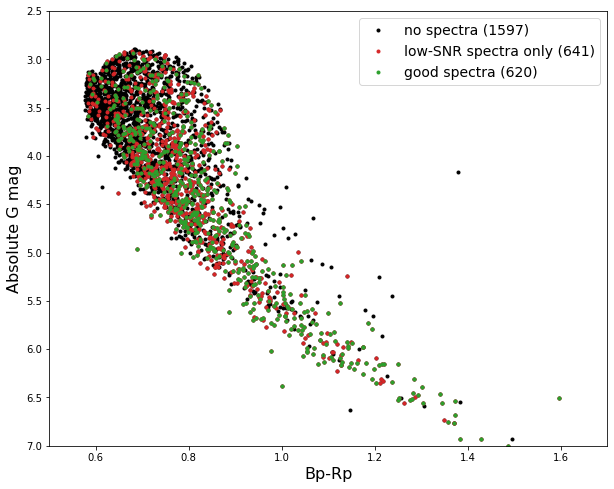

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ms = 6
ax.plot(sample['BPRP'], sample['Gmag'] + 5.*(np.log10(sample['Plx']/1.e3)+1), c='k', marker='.', ls='', ms=ms, 
        label='no spectra ({0})'.format(len(sample) - len(ok_sample)))
ax.plot(ok_sample['BPRP'], ok_sample['Gmag'] + 5.*(np.log10(ok_sample['Plx']/1.e3)+1), c='C3', marker='.', ls='', ms=ms, 
        label='low-SNR spectra only ({0})'.format(len(ok_sample) - len(good_sample)))
ax.plot(good_sample['BPRP'], good_sample['Gmag'] + 5.*(np.log10(good_sample['Plx']/1.e3)+1), c='C2', marker='.', ls='', ms=ms, 
        label='good spectra ({0})'.format(len(good_sample)))
ax.set_ylim([7,2.5])
ax.set_xlim([0.5,1.7])
plt.legend(fontsize=14)
ax.set_xlabel('Bp-Rp', fontsize=16)
ax.set_ylabel('Absolute G mag', fontsize=16)
plt.savefig('hires_cmag_snr{0}.png'.format(min_snr));

In [17]:
# cut on SNR:
min_snr = 200
good_sample = sample[sample['hires_maxres_snr'] >= min_snr]

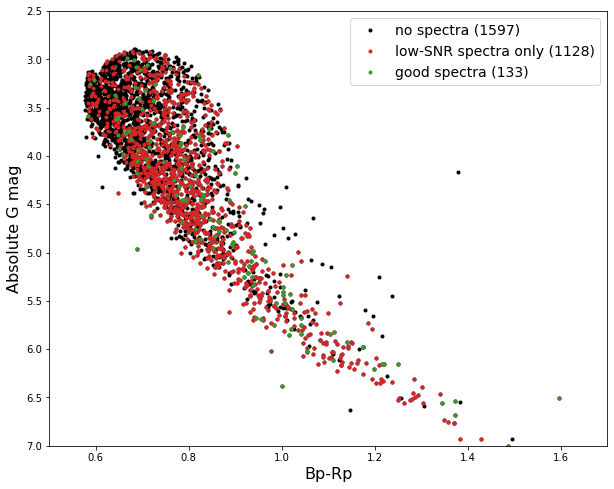

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ms = 6
ax.plot(sample['BPRP'], sample['Gmag'] + 5.*(np.log10(sample['Plx']/1.e3)+1), c='k', marker='.', ls='', ms=ms, 
        label='no spectra ({0})'.format(len(sample) - len(ok_sample)))
ax.plot(ok_sample['BPRP'], ok_sample['Gmag'] + 5.*(np.log10(ok_sample['Plx']/1.e3)+1), c='C3', marker='.', ls='', ms=ms, 
        label='low-SNR spectra only ({0})'.format(len(ok_sample) - len(good_sample)))
ax.plot(good_sample['BPRP'], good_sample['Gmag'] + 5.*(np.log10(good_sample['Plx']/1.e3)+1), c='C2', marker='.', ls='', ms=ms, 
        label='good spectra ({0})'.format(len(good_sample)))
ax.set_ylim([7,2.5])
ax.set_xlim([0.5,1.7])
plt.legend(fontsize=14)
ax.set_xlabel('Bp-Rp', fontsize=16)
ax.set_ylabel('Absolute G mag', fontsize=16)
plt.savefig('hires_cmag_snr{0}.png'.format(min_snr));